In [24]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
from matplotlib.dates import DateFormatter
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime as dt
import pandas as pd
import numpy as np
import os

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))


In [25]:
scales = [1, 2, 3, 4, 5, 7, 9, 10, 13, 19, 26, 37, 51, 71, 100, 138, 193, 268, 372, 517,719,1000]
df_ntr = pd.DataFrame()
for scale in scales:
    df = pd.read_csv(os.path.join(ROOT_DIR,"multiscale_results",f"results_{scale}","All_Results.csv"), index_col="Date", parse_dates=["Date"])
    df = df.filter(["Resonance","Novelty","Transience"])
    df = df.rename(columns={"Resonance":f"Resonance_{scale}","Novelty":f"Novelty_{scale}","Transience":f"Transience_{scale}"})
    df_ntr = pd.concat([df_ntr, df], axis=1)

for scale in scales:
    model = smf.ols(formula=f"Resonance_{scale} ~ Novelty_{scale}", data=df_ntr)
    results = model.fit()
    df_ntr[f"Resonance_{scale}_predicted"] = results.predict(df_ntr[f"Novelty_{scale}"])
    df_ntr[f"Resonance_{scale}_delta"] = df_ntr[f"Resonance_{scale}"] - df_ntr[f"Resonance_{scale}_predicted"]

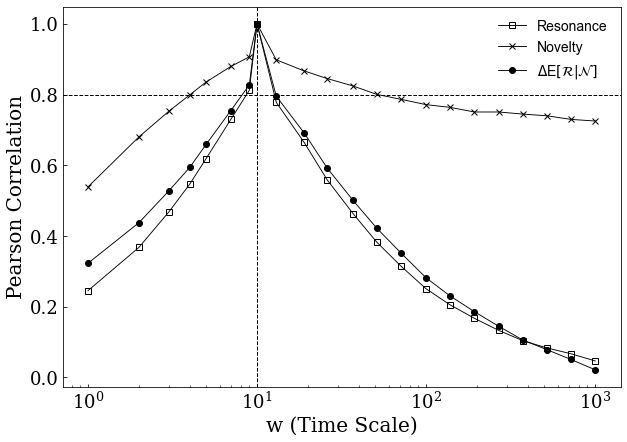

In [26]:
df_ntr_crop = df_ntr.iloc[1000:-1000,:]
df_ntr_crop.head(60)
p_resonance = [pearsonr(df_ntr_crop["Resonance_10"], df_ntr_crop[f"Resonance_{scale}"])[0] for scale in scales]
p_novelty = [pearsonr(df_ntr_crop["Novelty_10"], df_ntr_crop[f"Novelty_{scale}"])[0] for scale in scales]
p_transience = [pearsonr(df_ntr_crop["Transience_10"], df_ntr_crop[f"Transience_{scale}"])[0] for scale in scales]
p_delta = [pearsonr(df_ntr_crop["Resonance_10_delta"], df_ntr_crop[f"Resonance_{scale}_delta"])[0] for scale in scales]
df_all = pd.DataFrame({"Scale":scales, "Resonance":p_resonance, "Novelty":p_novelty, "Transience":p_transience, "Resonance_delta":p_delta})
df_all = df_all.set_index("Scale")

def corr_plot():
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(df_all.index.values, df_all["Resonance"], label="Resonance", marker="s", fillstyle="none", lw=0.9,c="k")
    ax.plot(df_all.index.values, df_all["Novelty"], label="Novelty", marker="x", lw=0.9,c="k")
    ax.plot(df_all.index.values, df_all[f"Resonance_delta"], label="\u0394E$[\mathcal{R}|\mathcal{N}]$", marker="o", lw=0.9,c="k")
    #remove label box border
    #ax.plot(df_all.index.values, df_all["Transience"], label="Transience", marker="s")
    ax.axhline(y=0.8, color="k", linestyle="--", lw=1)
    ax.axvline(x=10, color="k", linestyle="--", lw=1)
    ax.set_xscale("log")
    ax.set_xlabel("w (Time Scale)")
    ax.set_ylabel("Pearson Correlation")
    L=ax.legend(frameon=False)
    plt.setp(L.texts, family='Arial') 
    plt.show()
    return fig

fig = corr_plot()
fig.savefig(os.path.join(ROOT_DIR, "figures", "correlation", f"Correlation.svg"), format="svg", dpi=1000, bbox_inches="tight")